# Paramétrage de l'environnement de travail et import des packages

In [46]:
%cd "C:/Users/user/Desktop/data_science_documents/data_science_projets_perso/projet_housing_prediction/housing-prediction"

C:\Users\user\Desktop\data_science_documents\data_science_projets_perso\projet_housing_prediction\housing-prediction


In [47]:
from pathlib import Path

%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

ROOT = Path().resolve()
sys.path.append(str(ROOT / "03_src"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
import pandas as pd
import numpy as np
from cheat_tools.data_manipulation import fillna_multi, multi_astype

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.calibration import CalibratedClassifierCV

from sklearn.preprocessing import StandardScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn import set_config

from cheat_tools.machine_learning import resume_metriques_modele, graphique_courbe_roc, graphique_courbe_pr, graphique_courbe_calibration, waterfall_plot
import matplotlib.pyplot as plt
import shap

In [97]:
chemin_repo = Path(r"C:\Users\user\Desktop\data_science_documents\data_science_projets_perso\projet_housing_prediction\housing-prediction")


# Informations rapides sur la base de données

**Import de la base de données**

In [98]:
data_housing = pd.read_csv(f"{chemin_repo}/01_data/02_processed/03_econometrics/housing_data_econometrics_processed.csv",
                           dtype={'id_annonce':"object"})

In [99]:
data_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26647 entries, 0 to 26646
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_annonce                 26647 non-null  object 
 1   code_insee                 26647 non-null  object 
 2   property_type              26647 non-null  object 
 3   taille_agglomeration       26421 non-null  object 
 4   est_attrait_touristique    26647 non-null  int64  
 5   nb_rooms_bins              26505 non-null  object 
 6   approximate_latitude       26647 non-null  float64
 7   approximate_longitude      26647 non-null  float64
 8   densite_services_rayon     26647 non-null  float64
 9   size_c                     26478 non-null  float64
 10  taux_criminalite_1000_c    26419 non-null  float64
 11  population_c               26445 non-null  float64
 12  nb_photos_c                26647 non-null  float64
 13  size_2_c                   26478 non-null  flo

In [100]:
data_housing["target"].mean()

0.3461552895260254

# Création du modèle de ML

**Passage des valeurs manquantes des variables catégorielles et numériques en modalité 'missing'**

In [101]:
data_housing["taille_agglomeration"] = data_housing["taille_agglomeration"].fillna("missing")
data_housing["nb_rooms_bins"] = data_housing["nb_rooms_bins"].fillna("missing")

In [102]:
multi_astype(
    data_housing,
    ["property_type","taille_agglomeration","nb_rooms_bins"],
    "string"
)

property_type: object → string
taille_agglomeration: object → string
nb_rooms_bins: object → string

Succès: 3/3


In [103]:
data_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26647 entries, 0 to 26646
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_annonce                 26647 non-null  object 
 1   code_insee                 26647 non-null  object 
 2   property_type              26647 non-null  string 
 3   taille_agglomeration       26647 non-null  string 
 4   est_attrait_touristique    26647 non-null  int64  
 5   nb_rooms_bins              26647 non-null  string 
 6   approximate_latitude       26647 non-null  float64
 7   approximate_longitude      26647 non-null  float64
 8   densite_services_rayon     26647 non-null  float64
 9   size_c                     26478 non-null  float64
 10  taux_criminalite_1000_c    26419 non-null  float64
 11  population_c               26445 non-null  float64
 12  nb_photos_c                26647 non-null  float64
 13  size_2_c                   26478 non-null  flo

**Split Train/Test**

In [104]:
set_config(transform_output="pandas")

In [105]:
X = data_housing.drop(columns=["target","id_annonce","code_insee"])  
Y = data_housing["target"]                 


X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.2,          
    random_state=123,       
    stratify=Y                                  
)

**Selection du modèle et des hyperparamètres**

In [106]:
# Modèle (Régression logistique avec pénalisation L2)
logit = LogisticRegression(
    penalty="l2",        
    solver="lbfgs",      
    fit_intercept=True,
    max_iter=2000,
    class_weight=None,   
    random_state=42,
    n_jobs=-1
)

# Hyperparamètres (Equilibré)
param_logit = {
    "model__C": loguniform(1e-4, 1e2),   
}


**Création de la Pipeline & Tuning des hyperparamètres**

In [110]:
# Imputation des valeurs numériques manquantes via regression XGBoost
xgb=XGBRegressor(
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)

etape_1 = ColumnTransformer([
    ('xgb_imputer',
     IterativeImputer(estimator=xgb,max_iter=5,random_state=42),
     make_column_selector(dtype_include=np.number))
], remainder="passthrough")


# Standardisation des variables numériques
etape_2 = ColumnTransformer([
    ('scaler',
     StandardScaler(),
     make_column_selector(dtype_include=np.number))
], remainder="passthrough")


# One Hot Encoding  sur les variables catégorielles
etape_3 = ColumnTransformer([
    ('ohe',
     OneHotEncoder(drop='first',sparse_output=False,handle_unknown='ignore'),
     make_column_selector(dtype_exclude=np.number))
], remainder="passthrough")


# Assemblage de la Pipeline
pipeline_complete = Pipeline([
    ('xgb_imputer', etape_1),
    ('scaler',etape_2),
    ('ohe', etape_3),
    ('model', logit)
])


# Tuning des hyperparamètres 
recherche = RandomizedSearchCV(
    estimator=pipeline_complete,
    param_distributions=param_logit,
    n_iter = 10,
    scoring = {
            "accuracy":"accuracy",
            "f1":"f1",
            "precision":"precision",
            "recall":"recall",
            "roc_auc":"roc_auc",
            "average_precision":"average_precision",
            "neg_brier_score":"neg_brier_score"
            },
    cv = 3,     
    return_train_score = True,
    refit = False,
    random_state = 123,
    n_jobs = -1,
    verbose = 3,
    error_score='raise'
)

recherche.fit(X_train, Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('xgb_imputer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('xgb_imputer',
                                                                               IterativeImputer(estimator=XGBRegressor(base_score=None,
                                                                                                                       booster=None,
                                                                                                                       callbacks=None,
                                                                                                                       colsample_bylevel=None,
                                                                                                                       colsample_bynode=None,
                                                                                                                       colsample_bytree=None,
                                                                                                                       early_stopping_rounds=None,
                                                                                                                       enable_categoric...
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020944965190>},
                   random_state=123, refit=False, return_train_score=True,
                   scoring={'accuracy': 'accuracy',
                            'average_precision': 'average_precision',
                            'f1': 'f1', 'neg_brier_score': 'neg_brier_score',
                            'precision': 'precision', 'recall': 'recall',
                            'roc_auc': 'roc_auc'},
                   verbose=3)

**Selection du meilleur modèle** 

In [111]:
KPIs = [
    "mean_train_roc_auc", "mean_train_precision","mean_train_recall","mean_train_neg_brier_score",
    "mean_test_roc_auc", "mean_test_precision", "mean_test_recall", "mean_test_neg_brier_score",
    "std_test_roc_auc","std_test_precision","std_test_recall",
    "rank_test_roc_auc","rank_test_precision","rank_test_recall",
    "mean_fit_time",
    "mean_score_time"
]

liste_modeles = pd.DataFrame(recherche.cv_results_)

liste_modeles[KPIs].sort_values("rank_test_roc_auc")

,mean_train_roc_auc,mean_train_precision,mean_train_recall,mean_train_neg_brier_score,mean_test_roc_auc,mean_test_precision,mean_test_recall,mean_test_neg_brier_score,std_test_roc_auc,std_test_precision,std_test_recall,rank_test_roc_auc,rank_test_precision,rank_test_recall,mean_fit_time,mean_score_time
6,0.901965,0.799988,0.697384,-0.116847,0.901240,0.798058,0.694673,-0.117298,0.002381,0.001059,0.012988,1,10,1,50.377076,0.463619
4,0.901956,0.801295,0.696842,-0.116884,0.901229,0.798620,0.693860,-0.117328,0.002359,0.001030,0.013286,2,9,2,49.381229,0.495298
0,0.901948,0.801405,0.696503,-0.116901,0.901218,0.798819,0.693589,-0.117343,0.002353,0.001469,0.013276,3,8,3,66.792153,0.609257
7,0.901942,0.801843,0.696503,-0.116912,0.901214,0.798970,0.693182,-0.117352,0.002347,0.001292,0.013583,4,7,4,49.741256,0.476284
3,0.901367,0.803975,0.690947,-0.117450,0.900693,0.801747,0.688304,-0.117841,0.002295,0.001097,0.012706,5,6,5,53.932507,0.477980
8,0.900133,0.809234,0.685594,-0.118532,0.899511,0.807536,0.683560,-0.118889,0.002464,0.001801,0.012502,6,3,6,50.319005,0.490007
5,0.897994,0.810857,0.674549,-0.120425,0.897414,0.810575,0.673939,-0.120760,0.002909,0.005568,0.011949,7,1,7,50.129991,0.476485
9,0.896180,0.808829,0.664588,-0.122026,0.895585,0.808101,0.663233,-0.122348,0.003302,0.004286,0.011131,8,2,8,37.747590,0.346748
1,0.885643,0.807744,0.616953,-0.131138,0.885194,0.807503,0.617021,-0.131380,0.004756,0.009050,0.014574,9,4,9,58.627375,0.522890
2,0.877908,0.805283,0.566878,-0.138404,0.877544,0.802906,0.565524,-0.138589,0.005271,0.009171,0.014604,10,5,10,54.050467,0.504752


In [116]:
best_params = liste_modeles.loc[6,"params"]                    
pipeline_complete.set_params(**best_params)  

Pipeline(steps=[('xgb_imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('xgb_imputer',
                                                  IterativeImputer(estimator=XGBRegressor(base_score=None,
                                                                                          booster=None,
                                                                                          callbacks=None,
                                                                                          colsample_bylevel=None,
                                                                                          colsample_bynode=None,
                                                                                          colsample_bytree=None,
                                                                                          early_stopping_rounds=None,
                                                                                          enable_categorical=False,
                                                                                          eval_metric=None,
                                                                                          feature_types=None,
                                                                                          gamma=Non...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002094B92A610>)])),
                ('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002094B92BA10>)])),
                ('model',
                 LogisticRegression(C=76.66289057556018, max_iter=2000,
                                    n_jobs=-1, random_state=42))])

**Entrainement du modèle**

In [117]:
pipeline_complete.fit(X_train,Y_train)

c:\Users\user\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Pipeline(steps=[('xgb_imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('xgb_imputer',
                                                  IterativeImputer(estimator=XGBRegressor(base_score=None,
                                                                                          booster=None,
                                                                                          callbacks=None,
                                                                                          colsample_bylevel=None,
                                                                                          colsample_bynode=None,
                                                                                          colsample_bytree=None,
                                                                                          early_stopping_rounds=None,
                                                                                          enable_categorical=False,
                                                                                          eval_metric=None,
                                                                                          feature_types=None,
                                                                                          gamma=Non...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002094B92A610>)])),
                ('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002094B92BA10>)])),
                ('model',
                 LogisticRegression(C=76.66289057556018, max_iter=2000,
                                    n_jobs=-1, random_state=42))])

In [118]:
train_proba = pipeline_complete.predict_proba(X_train)[:,1]
train_pred = Y_train

**Prédiction sur l'échantillon 'test'**

In [120]:
test_proba = pipeline_complete.predict_proba(X_test)[:,1]
test_pred = pipeline_complete.predict(X_test)

# Analyse de la performance du modèle de ML

**Résumé des métriques**

In [128]:
resume_metriques_modele(
    Y_train,
    Y_test,
    test_pred,
    train_proba,
    test_proba
)

MÉTRIQUES DE PERFORMANCE
Accuracy                  : 0.8319
Precision                 : 0.7960
Recall                    : 0.6916
F1-Score                  : 0.7401
Average Precision         : 0.8449
ROC-AUC                   : 0.9027
Brier Score (Train)       : 0.1168
Brier Score (Test)        : 0.1169

MATRICE DE CONFUSION
                     Prédit Négatif | Prédit Positif
Réel Négatif               3158 |            327
Réel Positif                569 |           1276

Spécificité              : 0.9062
Faux Positifs            : 327
Faux Négatifs            : 569


**Courbe ROC**

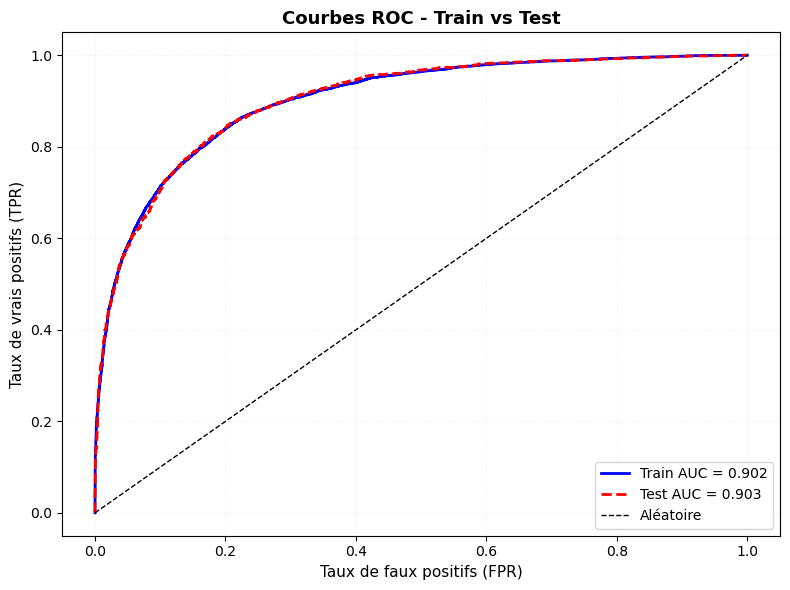


RÉSULTATS ROC-AUC
AUC Train    : 0.9020
AUC Test     : 0.9027
Écart        : -0.0007
✓ Écart acceptable


In [129]:
graphique_courbe_roc(
    Y_train,train_proba,
    Y_test,test_proba
)

**Courbe PR**

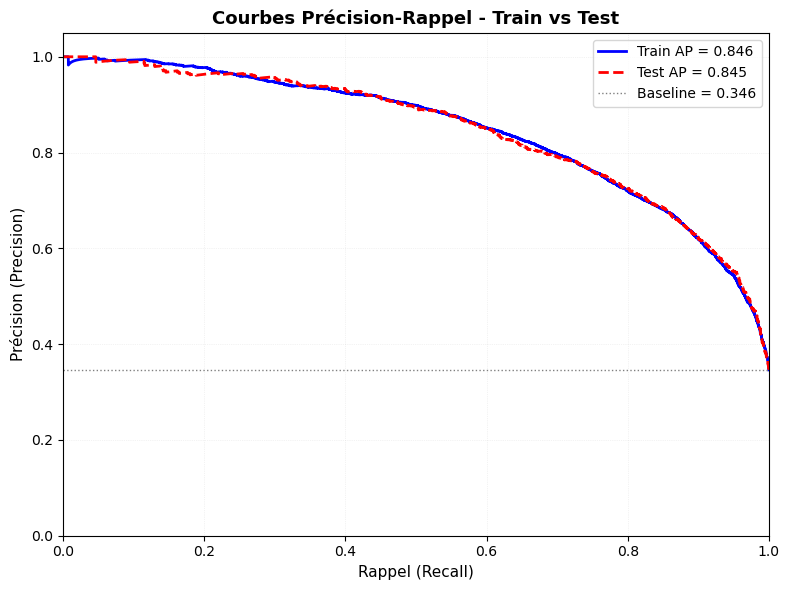


RÉSULTATS PRÉCISION-RAPPEL
AP Train     : 0.8455
AP Test      : 0.8449
Écart        : 0.0007
Baseline     : 0.3462
✓ Écart acceptable
Lift vs baseline : 2.44x


In [134]:
graphique_courbe_pr(
    Y_train,train_proba,
    Y_test,test_proba
)

**Courbe de calibration**

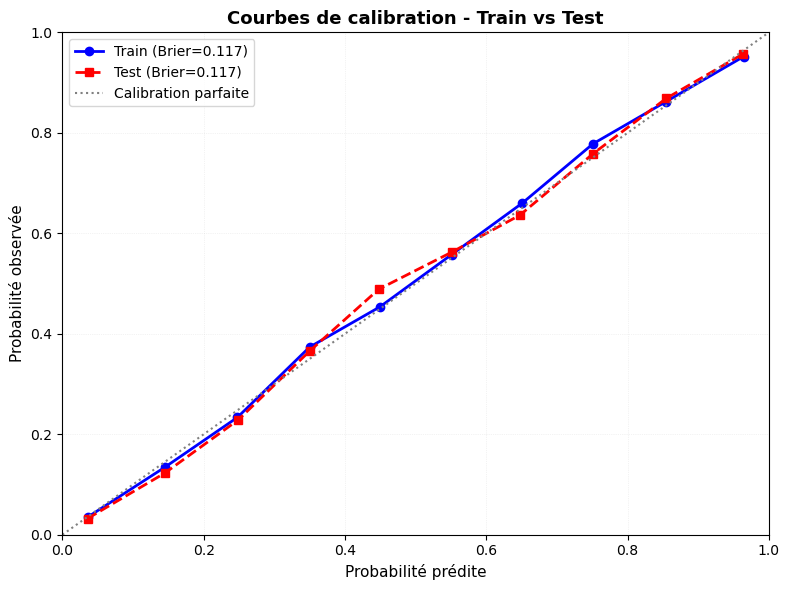


RÉSULTATS DE CALIBRATION
Brier Score Train : 0.1168
Brier Score Test  : 0.1169
Écart Brier       : -0.0001

ECE Train         : 0.0117
ECE Test          : 0.0153

---------------------------------------------
INTERPRÉTATION :
✓ Bonne calibration (Brier < 0.25)
✓ Erreur de calibration faible (ECE < 0.05)


In [133]:
graphique_courbe_calibration(
    Y_train,train_proba,
    Y_test,test_proba
)

# Interprétation SHAP du modèle

**Initialisation**

In [136]:
# Appliquer toutes les étapes sans le modèle (étape 1 | étape 2 | étape 3)
X_train_proc = pipeline_complete[:-1].transform(X_train)

# Récuperer le modèle "nu"
logit_final = pipeline_complete.named_steps["model"]


# Initialisation de l'explainer
explainer = shap.LinearExplainer(logit_final, X_train_proc)

shap_values = explainer(X_train_proc)  

**Feature Importance**

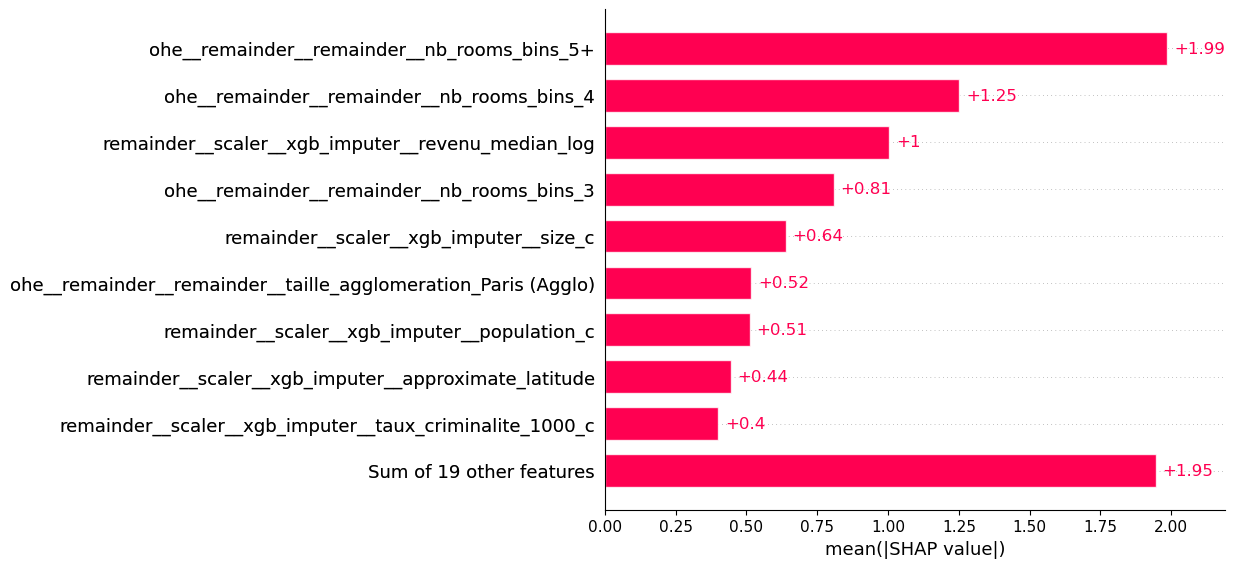

In [143]:
shap.plots.bar(shap_values, max_display=10)

**Beeswarm Plot**

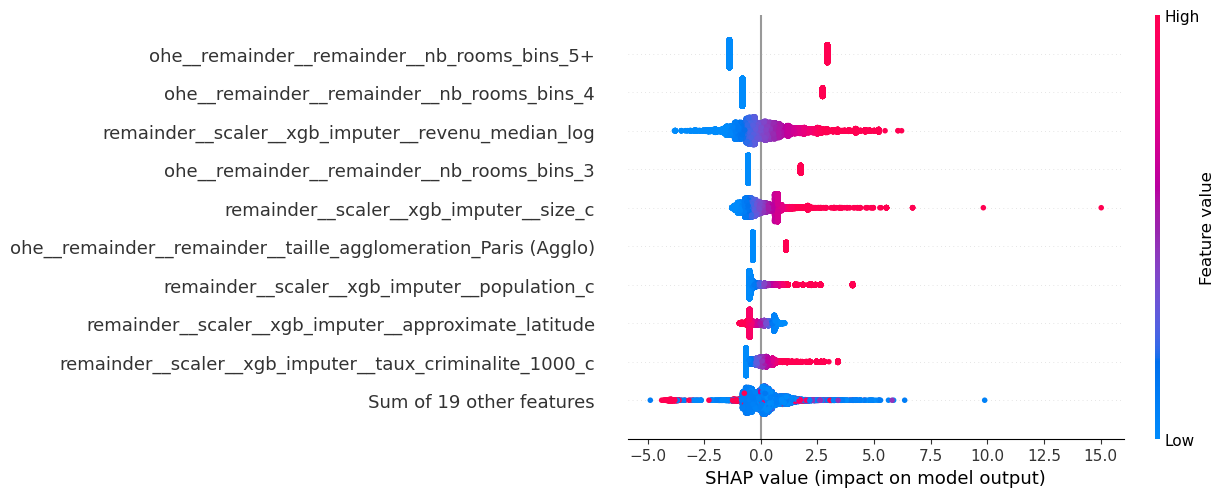

In [147]:
shap.plots.beeswarm(shap_values, max_display=10)

**Waterfall Plot**

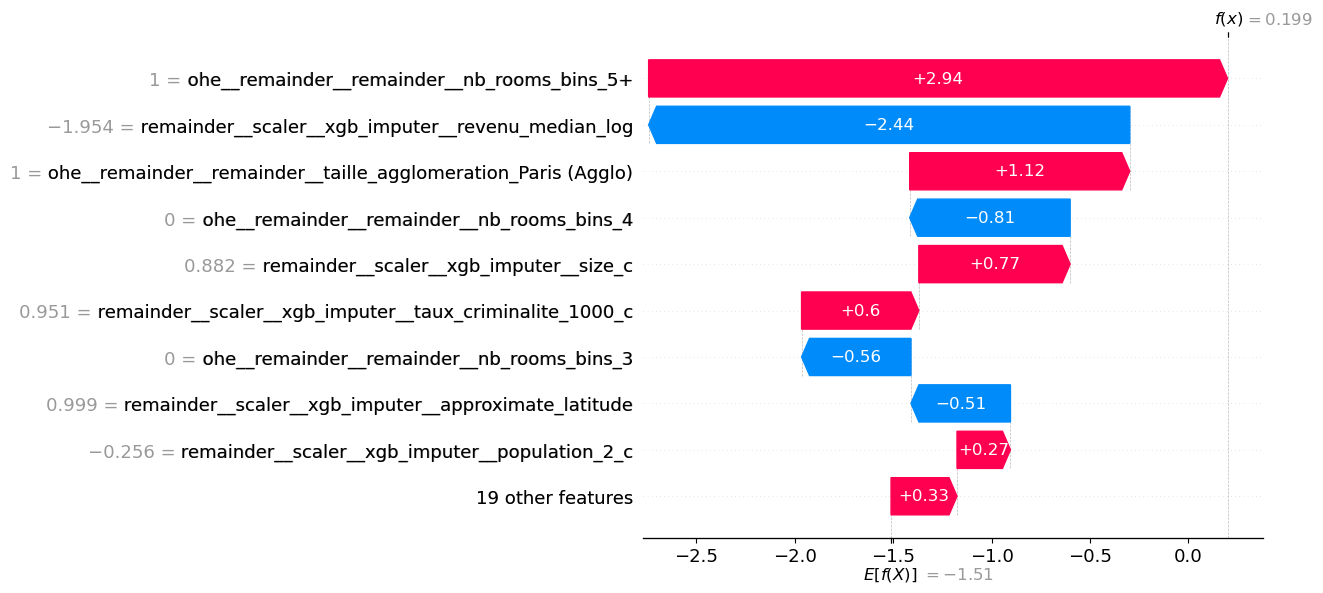

In [160]:
waterfall_plot(
    shap_values,
    X_train_proc,
    89,
    max_display=10
)